In [1]:
%matplotlib inline


# Empirical evaluation of the impact of k-means initialization


Evaluate the ability of k-means initializations strategies to make
the algorithm convergence robust as measured by the relative standard
deviation of the inertia of the clustering (i.e. the sum of distances
to the nearest cluster center).

The first plot shows the best inertia reached for each combination
of the model (``KMeans`` or ``MiniBatchKMeans``) and the init method
(``init="random"`` or ``init="kmeans++"``) for increasing values of the
``n_init`` parameter that controls the number of initializations.

The second plot demonstrate one single run of the ``MiniBatchKMeans``
estimator using a ``init="random"`` and ``n_init=1``. This run leads to
a bad convergence (local optimum) with estimated centers stuck
between ground truth clusters.

The dataset used for evaluation is a 2D grid of isotropic Gaussian
clusters widely spaced.


In [1]:
print(__doc__)

# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

random_state = np.random.RandomState(0)


Automatically created module for IPython interactive environment


Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


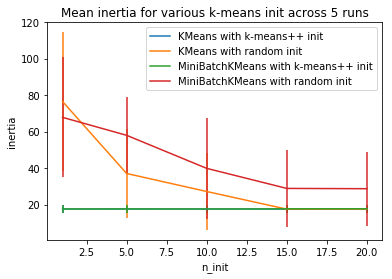

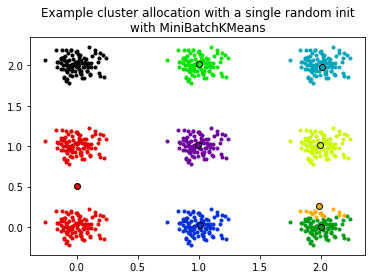

In [2]:

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size ** 2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j]
                        for i in range(grid_size)
                        for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1]))

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center
                        for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)

# Part 1: Quantitative evaluation of various init methods

fig = plt.figure()
plots = []
legends = []

cases = [
    (KMeans, 'k-means++', {}),
    (KMeans, 'random', {}),
    (MiniBatchKMeans, 'k-means++', {'max_no_improvement': 3}),
    (MiniBatchKMeans, 'random', {'max_no_improvement': 3, 'init_size': 500}),
]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(n_clusters=n_clusters, init=init, random_state=run_id,
                         n_init=n_init, **params).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(n_init_range, inertia.mean(axis=1), inertia.std(axis=1))
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(n_clusters=n_clusters, init='random', n_init=1,
                     random_state=random_state).fit(X)

fig = plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor=color, markeredgecolor='k', markersize=6)
    plt.title("Example cluster allocation with a single random init\n"
              "with MiniBatchKMeans")

plt.show()